### ILWISPy for time series data processing

Notebook prepared by Ben Maathuis, Bas Retsios and Willem Nieuwenhuis. ITC-University of Twente, Enschede. The Netherlands

Within this Notebook your are going to use ILWISPy in conjunction with a number of common used Python libraries, like Numpy and Matplotlib, which have already been introduced before. Also use is made here of Pandas.

Within this notebook we focus on time series data. A number of open data sources are used:
+ daily discharge and hourly temperature data obtained from GloFAS and ERA5-Land respectively, contained within the Copernicus Climate Data Store (see: https://cds.climate.copernicus.eu/)
+ water level data obtained from altimetry measurements. (see also: http://land.copernicus.eu/global/products/wl)
+ MODIS NDVI time series (see: https://modis.gsfc.nasa.gov/data/dataprod/mod13.php). The NDVI time series has been clipped to a specific area in Ethiopia, this to limit the file size. 
+ Furthermore some monthly climatological data on rainfall and temperature over Ethiopia are being used.

Attention will be given to the following aspects:
+ import and processing of Grib / geotiff formatted Raster Coverage data, merging time series data and visualization
+ derive statistics and calculations using time series data
+ review json formatted Feature Coverage data and visualization using Pandas
+ temporal filtering
+ derive climatology
+ anomaly calculations
+ time series change detection
+ calculations using time series

Before we start, first load the required libraries to run this Notebook. If there is a message after executing the cell below, ensure that you install, using the command from within your python folder 'python -m pip install ...*package*...', e.g. for Pandas: 'python -m pip install pandas'.

Sample data available at: https://filetransfer.itc.nl/pub/52n/ilwis_py/sample_data/Intro_Timeseries_ILWISPy.zip. Unzip the file. Here it is assumed that the data folder '/Intro_Timeseries_ILWISPy' is situated within the notebook folder! It is furthermore assumed that you have locally installed ILWIS386 for data visualization when data is written to disk. This will be especially important when visualizing the time series data and anomalies created in the later part of this notebook, e.g. using the animation functionality of ILWIS 386, in order to check the results obtained.

Prerequisite: You have reviewed the notebook 'Intro_ILWISPy.ipynb' and 'Intro_RS_ILWISPy', both available at: https://filetransfer.itc.nl/pub/52n/ilwis_py/notebooks/. Note that the files with postfix *_result.html* files show the processed results if the notebook would be executed.


Import required libraries and set your ILWISPy working directory

In [ ]:
#load required required libraries and install sitepackages
from ctypes import *
lib1 = cdll.LoadLibrary(r'/home/jovyan/.local/lib/libGLdispatch.so.0.0.0')
lib1 = cdll.LoadLibrary(r'/home/jovyan/.local/lib/libGLX.so.0.0.0')
lib1 = cdll.LoadLibrary(r'/home/jovyan/.local/lib/libGL.so.1.7.0')

lib1 = cdll.LoadLibrary('/opt/conda/lib/libpython3.11.so.1.0')
lib1 = cdll.LoadLibrary('/opt/conda/envs/openeo/lib/libQt5Gui.so.5')
lib1 = cdll.LoadLibrary('/opt/conda/envs/openeo/lib/libQt5Sql.so.5')
lib1 = cdll.LoadLibrary('/opt/conda/envs/openeo/lib/libQt5Concurrent.so.5')

!pip install pandas

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from matplotlib.colors import ListedColormap
import ilwis
from datetime import datetime, timedelta
import pandas as pd
from pandas import DataFrame
from json import load as jload

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#use the Python function os.getcwd() to retrieve the current folder used and add a sub-folder containing the sample data
work_dir = os.getcwd() + '/Intro_Timeseries_ILWISPy'

#set the working directory for ILWISPy
ilwis.setWorkingCatalog(work_dir)
print(work_dir)
ilwis.version()

### Copernicus climate data store GloFAS

The gridded river discharge data used below has been downloaded for a selected area, the Buzi catchment in Mozambique, for the years 2020 and 2021. The data represents the discharge in m3/sec (per pixel) generated by the GloFAS system (see: https://www.globalfloods.eu/). The data has already been retrieved in grib2 format and was dowloaded from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-historical?tab=form. The data is going to be assigned as an ILWISPy raster coverage in the cells below, the dimensions are checked (note that 2020 is a leap year!)

In [ ]:
glofas_2020 = ilwis.RasterCoverage('historical_2020.grib')

In [ ]:
glofas_2021 = ilwis.RasterCoverage('historical_2021.grib')

Retrieve some meta data information, like raster stack dimensions, some additional information on geometry, projection, map extent aand for 2020 some additional statistics 

In [ ]:
print(glofas_2020.size())#leap year!
print(glofas_2021.size())

Check some of the other meta data

In [ ]:
coordSys = glofas_2020.coordinateSystem()
print(coordSys.toWKT())
print()
print(coordSys.toProj4())
print()
print(glofas_2020.envelope())
print()
stats2020 = glofas_2020.statistics(ilwis.PropertySets.pHISTOGRAM)
#print(stats.histogram())
print(stats2020[ilwis.PropertySets.pMIN]) # minimum value on the map
print(stats2020[ilwis.PropertySets.pMAX]) # maximum value on the map
print()
stats2021 = glofas_2021.statistics(ilwis.PropertySets.pHISTOGRAM)
#print(stats.histogram())
print(stats2021[ilwis.PropertySets.pMIN]) # minimum value on the map
print(stats2021[ilwis.PropertySets.pMAX]) # maximum value on the map

Transform the stack (in ilwis format) to a 1D numpy array (using np.fromiter(iter()) for the two years under consideration, combine the two 1D arrays (using append) and transform back to a 3D array (using reshape)

In [ ]:
#create 1D arrays
glofas_2np_2020 = np.fromiter(iter(glofas_2020), np.float64, glofas_2020.size().linearSize())
glofas_2np_2021 = np.fromiter(iter(glofas_2021), np.float64, glofas_2021.size().linearSize())

#combine the two - using append
array_both = np.append(glofas_2np_2020, glofas_2np_2021)

#create a 3D stack of the tow years combined
glofas_2np = array_both.reshape((glofas_2020.size().zsize+glofas_2021.size().zsize, glofas_2020.size().ysize, glofas_2020.size().xsize))

In [ ]:
#check the dimensions obtained
print(glofas_2np.shape)

Create a simple interactive plot using MatPlotLib Imshow of the first layer

In [ ]:
# create a plot of the numpy array using MatPlotLib - Imshow
%matplotlib inline  
fig1 = plt.figure(figsize =(10, 7))
plt.imshow(glofas_2np[0], interpolation='none', vmin=0, vmax=350, cmap='jet')

plt.axis('on')
plt.colorbar(shrink=0.6)
plt.title('Discharge (m3-sec)')

We continue with inspection of the data, navigate with your mouse cursor over the map in the cell above and check the location X=50 and y=28, this is the outlet location of the Buzi River!

In the cell below the data for the outlet location is retrieved for 2020

In [ ]:
l = 28
c = 50 
z = (glofas_2020.size().zsize)
print(z)

Q_2020 = []
for n in range(0,(z)):
    point_value = (glofas_2020.pix2value(ilwis.Pixel(c,l,n)))
    Q_2020.append(point_value)

print('Values extracted for selected location:', Q_2020)

Repeat the procedure for 2021

In [ ]:
l = 28
c = 50 
z = (glofas_2021.size().zsize)
print(z)

Q_2021 = []
for n in range(0,(z)):
    point_value = (glofas_2021.pix2value(ilwis.Pixel(c,l,n)))
    Q_2021.append(point_value)

print('Values extracted for selected location:', Q_2021)

The two lists obtained above are now merged into a single list

In [ ]:
#concatonate 2 lists
Q_all = Q_2020 + Q_2021
print(len(Q_all))

Create an appropriate time stamp for the X-axis and check the output index list created

In [ ]:
# initializing date range for X-Axis
plot_date = datetime.strptime("01-1-2020", "%d-%m-%Y")

z = (glofas_2020.size().zsize+glofas_2021.size().zsize)

date_generated = pd.date_range(plot_date, periods=z)
print(date_generated.strftime("%d-%m-%Y"))

In [ ]:
#%matplotlib inline
fig2 = plt.figure(figsize =(14, 7))
plt.plot(date_generated, Q_all, label='Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m3/sec)')
plt.title('Discharge extracted for a given pixel')
plt.legend()

### Copernicus Climate Data Store ERA5-Land
Hourly temperature of air at 2m above the surface of land, sea or in-land waters is retrieved from the ERA5-Land Reanalysis for 20230101, from 00:00 to 23:00 UTC, in grib format, see also: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview 

Load the data.

In [ ]:
grib_in = ilwis.RasterCoverage('CDS_temperature.grib')

In [ ]:
print(grib_in.size())

In [ ]:
# select a raster band layer from the initial data stack, here band 0 - representing 00:00 UTC
# note numbering starts from 0
B1 = ilwis.do('selection',grib_in,"rasterbands(0)")

print()
print(B1.size().xsize)
print(B1.size().ysize)
print(B1.size().zsize)

Retrieve the other meta data

In [ ]:
coordSys = B1.coordinateSystem()
print(coordSys.toWKT())
print()
print(coordSys.toProj4())
print()
print(B1.envelope())
print()
stats = B1.statistics(ilwis.PropertySets.pHISTOGRAM, 256)
#print(stats.histogram())
print(stats[ilwis.PropertySets.pMIN]) # minimum value on the map
print(stats[ilwis.PropertySets.pMAX]) # maximum value on the map

In [ ]:
#%matplotlib inline
stats_input = B1.statistics(ilwis.PropertySets.pHISTOGRAM, 255) # here 255 bins are used to create the histogram
x=[a for (a,b) in stats_input.histogram()][:-1] 
y =[b for (a,b) in stats_input.histogram()][:-1]

plt.plot(x,y,label='Raster Map values')
plt.xlabel('Data Range')
plt.ylabel('Data Frequency')
plt.title('Raster Histogram')
plt.legend()

Display the imported band using MatplotLib Imshow

In [ ]:
b1_2np = np.fromiter(iter(B1), np.float64, B1.size().linearSize()) 
#now we overwrite the initial variable created
b1_2np = b1_2np.reshape((B1.size().ysize, B1.size().xsize))

In [ ]:
# create a plot of the numpy array using MatPlotLib - Imshow
%matplotlib inline
fig = plt.figure(figsize =(10, 7))
plt.imshow(b1_2np, interpolation='none', vmin=219, vmax=312, cmap='jet')

plt.axis('on')
plt.colorbar(shrink=0.45)
plt.title('2 meter Temperature on 2023-01-01')

Extract temperature value for a certain position, position can be selected  using interactive plot above.

In [ ]:
l = 832
c = 2087 
z = (grib_in.size().zsize)
print(z)

stack_value = []
for n in range(0,(z)):
    point_value = (grib_in.pix2value(ilwis.Pixel(c,l,n)))
    stack_value.append(point_value)

print('Values extracted for selected location:', stack_value)

In [ ]:
T_kelvin = np.array(stack_value)
T_celcius = T_kelvin-273.15
print(T_celcius)

In [ ]:
#%matplotlib inline
fig2 = plt.figure(figsize =(8, 6))
plt.plot(T_celcius, label='pixel value')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,23])
plt.xlabel('Hour of the day - 2023-01-01')
plt.ylabel('Temperature (Kelvin)')
plt.title('Diurnal temperature extracted for a given pixel')
plt.legend()

Create a sub-map

In [ ]:
#window definition X-min Y-max x-max y-min
grib_sub = ilwis.do('selection',grib_in,"boundingbox(2000 350, 2999 999)")
print(grib_sub.size())

Now some calculations to get mean, min, max and standard deviation of the 24 map layers. We use the operation 'aggregaterasterstatistics'. Here the mean is further elaborated upon, you can replace it with the other statistics.

In [ ]:
ilwis.operationMetaData('aggregaterasterstatistics')

In [ ]:
# calculate mean, minimum  maximum temperature and standard deviation for the given day
rc_mean = ilwis.do('aggregaterasterstatistics', grib_sub, 'mean')
rc_min = ilwis.do('aggregaterasterstatistics', grib_sub, 'min')
rc_max = ilwis.do('aggregaterasterstatistics', grib_sub, 'max')
rc_std = ilwis.do('aggregaterasterstatistics', grib_sub, 'standarddev')

In [ ]:
# check mean temperature for some location for column,row (x,y) respectively  
print(rc_mean.pix2value(ilwis.Pixel(500,100)))  

In [ ]:
#transform from Kelvin to Celsius
rc_meanC = ilwis.do('mapcalc','(@1 -273.15)', rc_mean)

In [ ]:
#calculate the histogram of the 3 images provided
rc_meanC_stat = rc_meanC.statistics(ilwis.PropertySets.pMIN|ilwis.PropertySets.pMAX|ilwis.PropertySets.pHISTOGRAM, 256)

#print Min and Max values
print(rc_meanC_stat.prop(ilwis.PropertySets.pMIN), rc_meanC_stat.prop(ilwis.PropertySets.pMAX))
rc_min = rc_meanC_stat.prop(ilwis.PropertySets.pMIN)
rc_max = rc_meanC_stat.prop(ilwis.PropertySets.pMAX)                            

In [ ]:
# create a plot of the numpy array using MatPlotLib - Imshow
# using the Mean
meanC_2np = np.fromiter(iter(rc_meanC), np.float64, rc_meanC.size().linearSize()) 
meanC_2np = meanC_2np.reshape((rc_meanC.size().ysize, rc_meanC.size().xsize))


%matplotlib inline
fig3 = plt.figure(figsize =(10, 7))
plt.imshow(meanC_2np, interpolation='none', vmin=rc_min, vmax=rc_max, cmap='jet')

plt.axis('on')
plt.colorbar(shrink=0.45)
plt.title('Mean temperature of air at 2m above the surface on 2023-01-01')

#### Plot water level data from Copernicus Global Land Service
We continue working with data obtained from altimetry measurements over lakes and major rivers. See also: http://land.copernicus.eu/global/products/wl. Two files are provided, one covering Lake Kariba (example for lake) and the other file covers the Jamuna (example for river). The data is provided in json format. You can also inspect the file using a text editor, note the attributes contained in the sections 'type', 'geometry', 'properties' and 'data'. 

The example provided below is showing how to retrieve and process the data, you can uncomment the input file for river or lake accordingly in the cell below.

In [ ]:
#Select the river or lake as input, comment of uncomment line below
#example river:
wl_in = work_dir+'/c_gls_WL_202102140004_Jamuna_ALTI_V2.1.0.json'

#example lake:
#wl_in = work_dir+'/c_gls_WL_202108272015_Kariba_ALTI_V2.1.0.json'

#load the data file as an ILWISPy feature coverage
fc = ilwis.FeatureCoverage(wl_in)
print("The file name selected is: ", fc)

Get some idea of what is contained in the data set

In [ ]:
print(fc.featureCount())
print(fc.featureCount(ilwis.it.POINT))
print(fc.attributeCount())

Check the feature data types / domain

In [ ]:
for i in range(fc.attributeCount()):
    col_domain = fc[i]
    print(col_domain)

Read the information provided for columnindex 1 'basin', etc. Also get an idea of the location, using the information provided by the geometry

In [ ]:
fiter = iter(fc)
f = next(fiter)
print('Basin = ', f['basin'])
basin = (f['basin'])

#uncomment if the input file is containing altimetry data over a river
print('object = ', f['river'])
object = (f['river'])

#uncomment if the input file is containing altimetry data over a lake
#print('object = ', f['lake'])
#object = (f['lake'])


geom = f.geometry()
pointiter = iter(geom)
point = next(pointiter)
#print(point)
x = (point.x)
y = (point.y)
print('Location =', x, y)

All information can be obtained using a loop over the attribute table

In [ ]:
for f in fc:
    for col in fc.attributeTable().columns():
        print(col + ': ' + str(f[col]))

Another way to loop over the attribute table is provided in the cell below

In [ ]:
for col in fc.attributeTable().columns():
    print(col + ': ' + str(fc.attributeTable().column(col)[0]))

Having inspected the meta data, we are going to load the section 'data' section as a Pandas dataframe and create a plot of the water level above the water surface reference datum. This is required as the data provided is not fully adhering to the common json format. Here a single point location is provided with additionally a number of obsevations, normally you would expect for each location the corresponding obesrvation (multi-point). As this is not the case here we open the file once more, but now with Pandas.

In [ ]:
wl = jload(open(wl_in))
Alti_data = DataFrame(wl['data'])
Alti_data.head()#display the first number of records and their column names

Implement some small adjustments in the active Pandas data frame, e.g. rename some column names and create a new column with only the date

In [ ]:
Alti_data['Date_only'] = pd.to_datetime(Alti_data.datetime) #change date format
Alti_data['Date_only'] = Alti_data.Date_only.dt.date #extract year-month-day portion of the date
Alti_data=Alti_data.rename(columns = {'water_surface_height_above_reference_datum':'WSH'})
Alti_data=Alti_data.rename(columns = {'water_surface_height_uncertainty':'Disp'})
del Alti_data['time']
Alti_data.head()

Create a final plot of the water level time series, including the uncertainty parameter and subsequently save this plot as a jpg image

In [ ]:
# Plot with matplotlib

%matplotlib inline
fig, ax = subplots(figsize=(16,6))

ax.errorbar(Alti_data['Date_only'], 
            Alti_data['WSH'], 
            yerr = Alti_data['Disp'],
            color = 'darkblue',
            ecolor = 'darkred',
            ls = '-',
            marker = '.',
            alpha = .8,
            label = 'Mean dispersion = %4.2f cm)'%(Alti_data['Disp'].mean()*100))


ax.set_xlabel('Observation period')
ax.set_ylabel('Water Surface Height (m)')
ax.legend(loc = 'best')
ax.grid()

# Set title and labels for axes
ax.set(title="Water Surface Height above Reference Datum for " + basin +" / " + object +  " at lon:" + " " + str(x) + " - lat: " + str(y))

In [ ]:
# To save the plot -uncomment the line below
#fig.savefig(work_dir+'/'+'TS_altimeter.jpg')

### Timesat filtering, extraction of climatology and calculation of anomalies

#### Data import

Provided is a time series of MODIS - NDVI maps (scaled 0-255) in geotif format from 'year - day of year' 2000-001  to 2020-353 (21 years), having a 16 day repeat interval - a total of 483 time steps (for 21 years and 23 ndvi maps per year). The maps are clipped based on the Woreda Fagta Lakoma, situated in the zone called Awi Agew in the Amhara region, Ethiopia. The data is provided as a GeoTiff.

Map showing the Area of Interest.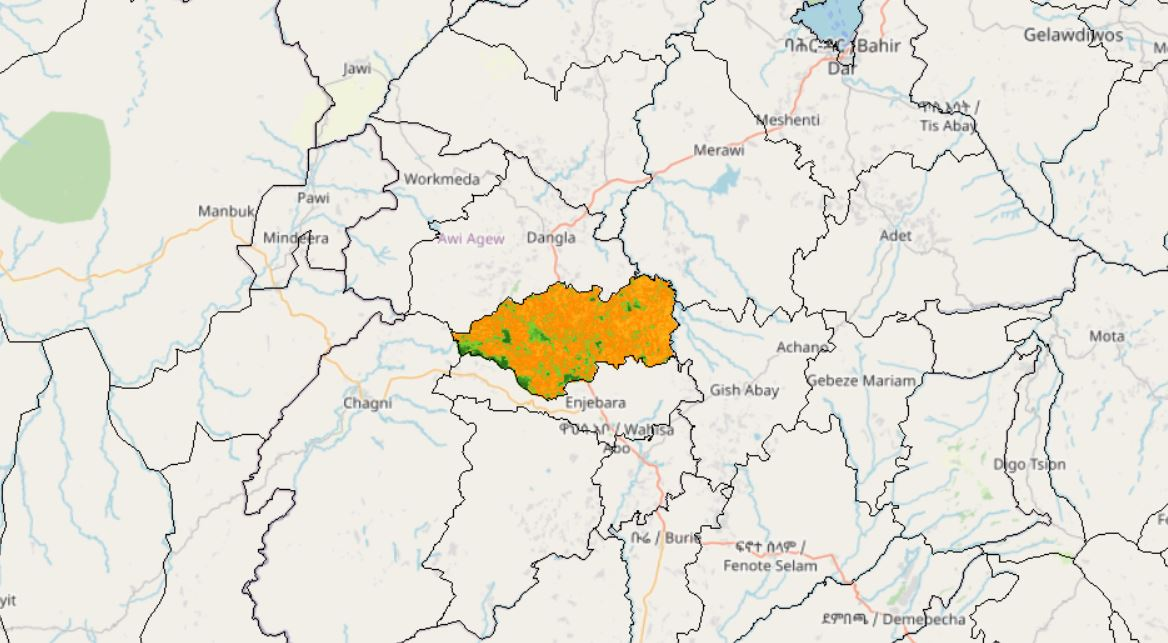

In [ ]:
rcTS = ilwis.RasterCoverage('ndvi_ts.tif')

In [ ]:
# probe its size
print(rcTS.size().xsize)
print(rcTS.size().ysize)
print(rcTS.size().zsize)

Let's have a look at the values for a specific pixel

In [ ]:
#get info on specific pixel for all temporal intervals, using the input data

l = 50
c = 50

non_filtered = []
for n in range(0,(rcTS.size().zsize)):
    ndvi_val = (rcTS.pix2value(ilwis.Pixel(c,l,n)))
    non_filtered.append(ndvi_val)

print("Values extracted for input time series:", non_filtered)

print()

Create a simple plot to inspect if there are anoalies - noice in the time series extracted for this pixel

In [ ]:
# create a simple plot showing the differences as a function of the temporal filter, using the settings applied
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(non_filtered, label='original time series')
plt.ylim([0, 275])
plt.xlabel('Time Series Range: 2000 to end 2021')
plt.ylabel('Digital Number')
plt.title('NDVI temporal profile for selected pixel at line: '+str(l) +' - column: '+ str(c))
plt.legend()

As can be observed from the plot generated above, there are quite a number of 'dips', which might represent no data (e.g. due to persistent cloud cover - even during 16 days / multiple overpasses) or other atmospheric issues that result mainly in ndvi values which are lower h higher than expected. This can be corrected for using a temporal filtering procedure. See also: https://www.sciencedirect.com/science/article/pii/S0034425718303985

#### Timesat Filtering
Satellite-derived NDVI time-series products are usually affected by contamination due to the atmosphere (aerosols and dust) or clouds, which results in a data set containing spikes and dips and therefore it is necessary to reduce this residual noise to improve the quality of the NDVI time-series data. 

In [ ]:
print(ilwis.operationMetaData('timesat'))   

##### TimeSat Filter options explanation:
+ iterationcount: The filter iterates using different filter window sizes; this aids in filtering without losing too much detail. By specifying the number of iterations automatically the window sizes are calculated. For example 4 iterations will generate window sizes of 3, 5, 7, and 9; the filter always starts with the smallest window size. The window size is calculated as 'current iteration' * 2 + 1.
+ upperenvelop: If set to true the filter will use the original value in favor of the fitted value if the fitted value is lower than the original value.
+ fitlastiteration: If set to true the filter will force the upper envelope for all filter window sizes except for the last. If set to false the envelope will also be forced to the upper envelope for the last windows size. This is only active when upperenvelop is set to true.
+ extendwindow: If set to true the input maplist is extended with data from the front appended to the end, and data from the end appended to the beginning to account for the filter window size. If set to false the filter assumes the extension is already done by the user

**Note that the timesat filter might take some time to process the imported time series**

In [ ]:
#execute timesat, note the settings applied
rcF=ilwis.do("timesat",(rcTS), 4, True, True, True)

In [ ]:
#If data has already been filtered uncomment line below to load the filtered time series data
#rcF = ilwis.RasterCoverage('ndv_filtered.tif')

After processing has been completed let's check the values for the the same pixel, but now the filtered results

In [ ]:
#get info on specific pixel for all temporal intervals for the filtered pixel

l = 50
c = 50

timesat_filtered = []
for n in range(0,(rcF.size().zsize)):
    ndvi_val = (rcF.pix2value(ilwis.Pixel(c,l,n)))
    timesat_filtered.append(ndvi_val)

print("Values extracted for filtered time series:", timesat_filtered)

Create a plot showing the original and filtered data. First create the date stamps for the x-axis

In [ ]:
# initializing date range for X-Axis
x=16
date_generated = []
for year in range(2000, 2021):
    start = datetime.strptime("01-01-" + str(year), "%d-%m-%Y")
    end = datetime.strptime("01-01-" + str(year+1), "%d-%m-%Y")
    date_generated = date_generated + [start + i * timedelta(days=x) for i in range(0, 1 + int((end-start).days / x))]
print(len(date_generated))

In [ ]:
# create a simple plot showing the differences as a function of the temporal filter, using the settings applied
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(date_generated, non_filtered, label='original time series')
plt.plot(date_generated, timesat_filtered, label='filtered time series')
plt.ylim([0, 275])
plt.xlabel('Time Series Range: 2000 - 2021')
plt.ylabel('Digital Number')
plt.title('NDVI temporal profile for selected pixel at line: '+str(l) +' - column: '+ str(c))
plt.legend()

In [ ]:
# uncomment the line below to store the filtered results in GeoTIFF format
#rcF.store("ndv_filtered.tif", "GTiff", "gdal")

#### Derive Climatology
To get an idea if a certain observation is in line with the average prevailing conditions you can compare the observation with the longer term average, or climatology. So now that we have a filtered time series, with the noice removed, we can calculate per time step over the years of observation, the average. The time series used here is 21 years and has 23 time steps per year, so the result should be a map stack of 23 layers containing the average (over the years under consideration) for each specific time step. 

In the cell below a definition is created which subsequently is executed in the cell further below. The time series is assumed to have the same number of time steps for each year under consideration. Here calendar years 2001 - 2021 are used.

Retrieve the layers to calculate the short term climatology, e.g. 20 years data! = 20 years * 23 layers = 460 layers, here starting from second year, for the next 20 years

In [ ]:
short_clim = []
short_clim = ilwis.do('selection',rcF,'rasterbands(23..483)')#select appropriate time range for climatology

Check map stack dimensions

In [ ]:
print(short_clim.size().xsize)
print(short_clim.size().ysize)
print(short_clim.size().zsize)

In the cell below a definition is created to calculate the climatology. Review the inline comments given below and execute the definition

In [ ]:
def computeClim(rc,start,end): 
    climatology = [] #new variable
    ix_start = start - 1 # ix_start is the "start" temporal interval (e.g. January 1)
    #print(start)
    while ix_start < end: #procedure will continue untill last layers
        ix = ix_start # ix is now January 1 of year 1
        #print(ix)
        selection = []
        while ix < nr_maps: # generate list of indices
            selection.append(str(ix))
            ix = ix + nr_time_steps # ix is now January 1 of the next year
        print(','.join(selection))
        rcSel = ilwis.do('selection', rc, 'rasterbands(' + ','.join(selection) + ')')#select appropriate layers per time step
        rcAvg = ilwis.do('aggregaterasterstatistics', rcSel, 'mean') #calculate the mean of all the layers per time step
        climatology.append(rcAvg) #add to already calculated layers
        ix_start = ix_start + 1 # jump to next temporal interval (e.g. January 16)
    return climatology

In [ ]:
#execute the definition 'computeClim', note the setting of the parameters that are being provided directly below

filtered_cor = short_clim # input filtered time series, note here full calendar years are provided
nr_maps = (filtered_cor.size().zsize) # length of the time series, here 10 years x 23 observations per year = 230
nr_time_steps = 23
start = 1

#run definition:
climatology = computeClim(filtered_cor,start,nr_time_steps) #output climatology = definition(input, start time-step, number of time-steps)

Get the map stack details on the climatology computed

In [ ]:
print(climatology[0].size()) #extract dimensions for the first layer
print(len(climatology)) #length of map stack

Select climatology for a given location for all time steps

In [ ]:
#get info on specific pixel for all temporal intervals for the filtered pixel

l = 50
c = 50

clim_sel = []
for n in range(0,len(climatology)):
    clim_val = (climatology[n].pix2value(ilwis.Pixel(c,l)))
    clim_sel.append(clim_val)

print("Values extracted for filtered time series:", clim_sel)

Extract for year 2013 (below average) to compare with climatology for selected location, 13 years x 23 time steps per year = 299, index / counting starts  from 0, so first time step  = 298 and last time step is 320, so for parameter 'rasterbands(b_start..b_end)' the index number are 'rasterbands(298..320)'

In [ ]:
year_poor = []
year_poor = ilwis.do('selection',rcF,'rasterbands(298..320)') #select appropriate layer range for specific year

l = 50
c = 50

year_below = []
for n in range(0,(year_poor.size().zsize)):
    year_val = (year_poor.pix2value(ilwis.Pixel(c,l,n)))
    year_below.append(year_val)

print("Values extracted for selected year filtered time series:", year_below)

Extract for year 2018 (above average) to compare with climatology for selected location, 18 years x 23 time steps per year = 414, index / counting starts  from 0, so first time step  = 413 and last time step is 436, so for parameter 'rasterbands(b_start..b_end)' the index number are 'rasterbands(413..436)'

In [ ]:
year_good = []
year_good = ilwis.do('selection',rcF,'rasterbands(413..436)') #select appropriate layer range for specific year

l = 50
c = 50

year_above = []
for n in range(0,(year_good.size().zsize)):
    year_val = (year_good.pix2value(ilwis.Pixel(c,l,n)))
    year_above.append(year_val)

print("Values extracted for selected year filtered time series:", year_above)

In [ ]:
# create a simple plot showing the differences between selected year and climatology
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(clim_sel, label='NDVI climatology', color = 'b', linestyle = '-', dashes=[6, 2])
plt.plot(year_above, label='NDVI above', color = 'g')
plt.plot(year_below, label='NDVI below', color = 'r')
plt.ylim([120, 240])
plt.xlabel('For selected Year - Time step')
plt.xticks([0, 2, 4 , 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel('Digital Number')
plt.title('NDVI comparison with climatology for selected pixel at line: '+str(l) +' - column: '+ str(c))
plt.legend()

Convert the climatology, as a list, to an ILWIS Map List. Define the number of leayer, read the full list as a 1D array. Prepare the ilwis destination Raster Coverage (x, y and z dimensions), read georeference and data type from know source. Finally create a 3D array. Check the output printed.

In [ ]:
#convert from list to ILWIS RasterCoverage - Maplist
data = np.fromiter(iter(climatology[0]), np.float64, climatology[0].size().linearSize())
for i in range(1, len(climatology)):
    data = np.concatenate((data, np.fromiter(iter(climatology[i]), np.float64, climatology[i].size().linearSize())))
    print(len(data))
    climatology_maplist = ilwis.RasterCoverage()
climatology_maplist.setSize(ilwis.Size(climatology[0].size().xsize, climatology[0].size().ysize, len(climatology)))
print(len(climatology))
climatology_maplist.setGeoReference(climatology[0].geoReference())
climatology_maplist.setDataDef(climatology[0].datadef())
climatology_maplist.array2raster(data)
print(climatology_maplist.size())

Store the results obtained as an ILWIS MapList, visualize the anomaly map stack created using the animation functions in ILWIS 386. Use as Representation 'anom.rpr'

In [ ]:
climatology_maplist.store('clim20y.mpl')

#### Compute anomalies
Anomalies are the deviation between the NDVI climatology (here the short term average) calculated and the actual values observed for the same time step for a given year. The year 2013 is used.

In [ ]:
clim_in = climatology_maplist
print(clim_in.size())
time_step_in = ilwis.do('selection',rcF,'rasterbands(298..320)')
print(time_step_in.size())

#calculate the anomalies per time step for a whole calendar year
anom_2013 = ilwis.do('mapcalc',' @1-@2', time_step_in, clim_in)

In [ ]:
l = 50
c = 50

year_anom = []
for n in range(0,(anom_2013.size().zsize)):
    anom_val = (anom_2013.pix2value(ilwis.Pixel(c,l,n)))
    year_anom.append(anom_val)

print("Values extracted for selected year anomaly time series:", year_anom)

Store your results and create an animation using ILWIS 386 to get an impression of the spatial distribution of the anomalies obtained.

In [ ]:
anom_2013.store('anomaly_2013.mpl')

In [ ]:
# create a simple plot showing the differences between selected year and climatology
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(year_anom, label='NDVI Anomaly')
plt.ylim([-50, 50])
plt.axhline(y = 0.0, color = 'r', linestyle = '-', dashes=[6, 2])
plt.xlabel('For selected Year - Time step')
plt.xticks([0, 2, 4 , 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel('Anomaly')
plt.title('NDVI anomaly comparison (actual - climatology) for selected pixel at line: '+str(l) +' - column: '+ str(c))
plt.legend()

### Time Series change detection
This notebook ends with an example of the use of multi temporal satellite image assessment for change detection. As example the Grand Ethiopian Renaissance Dam (see: https://en.wikipedia.org/wiki/Grand_Ethiopian_Renaissance_Dam) is used. To access the changes the images as recorded by Sentinel-1 are used. For information on the data review: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD. The data, retrieved from Google Earth Engine, was pre-processed. Some of the details:
+ window extent rectangle selected (in lon-lat WGS84): 34.6103, 10.5254, 35.7351, 11.3197 (EPSG:4326)
+ Polarization selected: VH
+ dates of the image composites:
        S1_VH_202001: composite created over time range from '2020-01-01' to '2020-01-31' - pre fill condition
        S1_VH_202009: composite created over time range from '2020-09-01' to '2020-09-30' - fill during rainy season 2020
        S1-VH_202108: composite created over time range from '2021-08-15' to '2021-09-15' - fill during rainy season 2021

The 3 images are already provided in an ILWIS file format, their data type is value and the backscatter unit is dB

In [ ]:
#import raster images provided
rc1 = ilwis.RasterCoverage('S1_VH_202001.mpr')
rc2 = ilwis.RasterCoverage('S1_VH_202009.mpr')
rc3 = ilwis.RasterCoverage('S1_VH_202108.mpr')

# get information on dimensions
print(rc1.size().xsize)
print(rc1.size().ysize)
print(rc1.size().zsize)

# check the georeference of the raster
print (rc3.geoReference().name())

Get yourself a bit familar with the image statistics, note the unit is in dB, check the minimum and maximum values of each of the images

In [ ]:
#calculate the histogram of the 3 images provided
rc1_stat = rc1.statistics(ilwis.PropertySets.pMIN|ilwis.PropertySets.pMAX|ilwis.PropertySets.pHISTOGRAM, 256)
rc2_stat = rc2.statistics(ilwis.PropertySets.pMIN|ilwis.PropertySets.pMAX|ilwis.PropertySets.pHISTOGRAM, 256)
rc3_stat = rc3.statistics(ilwis.PropertySets.pMIN|ilwis.PropertySets.pMAX|ilwis.PropertySets.pHISTOGRAM, 256)

#print Min and Max values
print(rc1_stat.prop(ilwis.PropertySets.pMIN), rc1_stat.prop(ilwis.PropertySets.pMAX))
print(rc2_stat.prop(ilwis.PropertySets.pMIN), rc2_stat.prop(ilwis.PropertySets.pMAX))
print(rc3_stat.prop(ilwis.PropertySets.pMIN), rc3_stat.prop(ilwis.PropertySets.pMAX))

In [ ]:
#prepare the histogram plot
x1=[a for (a,b) in rc1_stat.histogram()][:-1]
y1=[b for (a,b) in rc1_stat.histogram()][:-1]

x2=[a for (a,b) in rc2_stat.histogram()][:-1]
y2=[b for (a,b) in rc2_stat.histogram()][:-1]

x3=[a for (a,b) in rc3_stat.histogram()][:-1]
y3=[b for (a,b) in rc3_stat.histogram()][:-1]

From the histogram plot provided below give some special attention to the negative value range, which values represent water and could you think of a value providing the upper water limit?

In [ ]:
#plot the histogram of the three images
#plot inline
%matplotlib inline 
fig1 = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(x1,y1,label='202001')
plt.plot(x2,y2,label='202009')
plt.plot(x3,y3,label='202108')
plt.xlabel('Data Range')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.legend()
plt.title('full range')


plt.subplot(1, 2, 2)
plt.plot(x1,y1,label='202001')
plt.plot(x2,y2,label='202009')
plt.plot(x3,y3,label='202108')
plt.xlabel('Data Range')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.ylim([0,7500])
plt.xlim([-40,-20])
plt.legend()
plt.title('selected range over water')

In [ ]:
# extract water, eventually modify upper limit threshold
#for 202001
rc1w = ilwis.do('mapcalc','iff(@1 < -26, 1, 0)', rc1)
rc1w = ilwis.do('setvaluerange', rc1w, 0, 1, 0.01)

#for 202009
rc2w = ilwis.do('mapcalc','iff(@1 < -23.5, 1, 0)', rc2)
rc2w = ilwis.do('setvaluerange', rc2w, 0, 1, 0.01)

#for 202108
rc3w = ilwis.do('mapcalc','iff(@1 < -23, 1, 0)', rc3)
rc3w = ilwis.do('setvaluerange', rc3w, 0, 1, 0.01)


rc4w = ilwis.do('mapcalc','@1+@2+@3', rc1w, rc2w, rc3w)
rc4w = ilwis.do('setvaluerange', rc4w, 0, 3, 1)

rc4w.store('water_change.mpr')

In [ ]:
#rescale to display colour composite
rows = rc1.size().ysize
cols = rc1.size().xsize

rc1n = np.fromiter(iter(rc1), np.float64, rc1.size().linearSize()) 
rc1n = rc1n.reshape(rows,cols)
rc2n = np.fromiter(iter(rc2), np.float64, rc2.size().linearSize()) 
rc2n = rc2n.reshape(rows,cols)
rc3n = np.fromiter(iter(rc3), np.float64, rc3.size().linearSize()) 
rc3n = rc3n.reshape(rows,cols)

In [ ]:
#rescale to display classified water map
w_cl = np.fromiter(iter(rc4w), np.uint8, rc1.size().linearSize()) 
w_cl = w_cl.reshape(rows,cols)

In [ ]:
%matplotlib inline
plt.figure(figsize=(14,8))
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace= 0.3, 
                    hspace=0.3)
plt.subplot(2,2,1)
plt.imshow(rc1n, cmap= 'gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Coverage 1 = VH_Jan2020')
plt.grid(False)

plt.subplot(2,2,2)
plt.imshow(rc2n, cmap= 'gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Coverage 2 = VH_Sep2020')
plt.grid(False)

plt.subplot(2,2,3)
plt.imshow(rc3n, cmap= 'gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Coverage 3 = VH_Sep2021')
plt.grid(False)


plt.subplot(2,2,4)
plt.imshow(w_cl, cmap= 'jet', vmin=0, vmax=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('classified = water changes')

In [ ]:
#apply simpe scaling on original images
rc1b = ilwis.do('mapcalc','(@1 + 40)*5', rc1)
red = ilwis.do('setvaluerange', rc1b, 0, 255, 1)
rc2b = ilwis.do('mapcalc','(@1 + 40)*5', rc2)
green = ilwis.do('setvaluerange', rc2b, 0, 255, 1)
rc3b = ilwis.do('mapcalc','(@1 + 40)*5', rc3)
blue = ilwis.do('setvaluerange', rc3b, 0, 255, 1)

In [ ]:
redfc = np.fromiter(iter(red), np.ubyte, rc1.size().linearSize()) 
redfc = redfc.reshape(rows,cols)
greenfc = np.fromiter(iter(green), np.ubyte, rc2.size().linearSize()) 
greenfc = greenfc.reshape(rows,cols)
bluefc = np.fromiter(iter(blue), np.ubyte, rc3.size().linearSize()) 
bluefc = bluefc.reshape(rows,cols)

fc_reservoir = np.dstack((redfc, greenfc, bluefc))

In [ ]:
#plot interactive colour composite
%matplotlib inline
plt.figure(figsize=(8,6))
plt.imshow(fc_reservoir)

#### Some more calculations examples using time series
##### Aridity Index
Time series analysis requires calculations to be performed on map lists / map stacks. To demonstrate the map list calculation functionality an aridity index (AI) is going to be calculated to obtain an impression using a numerical indicator of the degree of dryness of the climate at a given location. Here the AI as proposed by De Martonne is used. The ‘De Martonne’ Aridity index (IndexDM) defines aridity as the ratio of precipitation to mean temperature according to the equation below and classifies these into different climate types. 
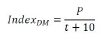
Where: 
+ P = annual average precipitation (mm) 
+ t = annual average temperature in degrees Celsius  

Climatologies of the two parameters are provided, first load these as Raster Coverages

In [ ]:
Tclim = ilwis.RasterCoverage('at_avg_climatology.mpl')
Pclim = ilwis.RasterCoverage('pcp_climatology.mpl')

To calculate de Martone Index (DM) first the sum of the precipitation has to be obtained as well as the average temperature

In [ ]:
Psum = ilwis.do('aggregaterasterstatistics', Pclim, 'sum')
Tavg = ilwis.do('aggregaterasterstatistics', Tclim, 'mean')

Visualize the input data

In [ ]:
# create a plot of the numpy array using MatPlotLib - Imshow

Psum_2np = np.fromiter(iter(Psum), np.float64, Psum.size().linearSize()) 
Psum_2np = Psum_2np.reshape((Psum.size().ysize, Psum.size().xsize))

Tavg_2np = np.fromiter(iter(Tavg), np.float64, Tavg.size().linearSize()) 
Tavg_2np = Tavg_2np.reshape((Tavg.size().ysize, Tavg.size().xsize))

#plot inline
%matplotlib inline 
fig1 = plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(Psum_2np, vmin=1, vmax=2500, cmap='jet')
plt.colorbar(fraction=0.025)
plt.title('Precipitation')
plt.subplot(1, 2, 2)
plt.imshow(Tavg_2np,vmin=1, vmax=35, cmap='jet')
plt.title('Temperature')
plt.colorbar(fraction=0.025)

Now we still need to classify the data according to the Aridity Index as proposed by De Martonne, classes are given below. 

Climate type | Aridity Index | code
---:|---:|---:|
Arid | 0 - 10 | 1
Semi-arid | 10 - 20 | 2
Mediterranean | 20 - 24 | 3
Semi-humid | 24 - 28 | 4
Humid | 28 - 35 | 5
Very humid | 35 - 55 | 6
Extremely humid | > 55 | 7

Start De Martonne Index calculation using the statisitics from the time series obtained.

In [ ]:
dm_index = ilwis.do('mapcalc','@1/(@2+10)', Psum, Tavg)
#dm_index.store('dmindex.mpr')

To classify the index we are going to create a domain and slice the 'continuous' data range of 'dm_index' into a number of discrete classes, specified according to the table above. 

In [ ]:
#note the slicing operation parameters required
print(ilwis.operationMetaData('sliceraster'))

From the operation MetaData a domain (specifying the name and data range) to slice the full data range is required. In the cell below an interval domain is created according to the class assignment proposed by De Martonne.

In [ ]:
# create a new NumericItemRange and fill it with required class items
dmrange = ilwis.NumericItemRange()
dmrange.add(('Arid', 0.0, 10.0, 1.0))
dmrange.add(('Semi-arid', 10.0, 20.0, 1.0))
dmrange.add(('Mediterranean', 20.0, 24.0, 1.0))
dmrange.add(('Semi-humid', 24.0, 28.0, 1.0))
dmrange.add(('Humid', 28.0, 35.0, 1.0))
dmrange.add(('Very humid', 35.0, 55.0, 1.0))
dmrange.add(('Extremely humid', 55.0, 500.0, 1.0))

#assign the range to a new ItemDomain
dm_dom = ilwis.ItemDomain(dmrange)

Conduct the slicing operation and to check the results obtained in ILWIS 386 uncomment the last line in the cell below

In [ ]:
dm_indexcl = ilwis.do('sliceraster', dm_index, dm_dom)
#dm_indexcl.store('dm_indexcl.mpr')

The same can also be done using the map calculation operator, note the equation provided below and execute the cell

In [ ]:
#apply the De Martonne class intervals using the code column from the Aridity Index table above
#note here a backslash is used for readability of the equation

dm_indexcl_mc =ilwis.do('mapcalc','iff((@1>=0)and(@1<10),1,iff((@1>=10)and(@1<20),2, \
iff((@1>=20)and(@1<24),3,iff((@1>=24)and(@1<28),4,iff((@1>=28)and(@1<35),5,iff((@1>=35)and(@1<55),6, \
iff(@1>=55,7,?)))))))', dm_index)

##### Precipitation Concentration Index
As can be observed above, there is a large variability in precipitation in time and space. Also an index is available to evaluate the rainfall distribution and rain concentration. Here the Precipitation Concentration Index (PCI) method according to Michiels, Gabriels and Hartmann (1992) is going to be applied. In this index, the higher the PCI, the more irregular and greater the precipitation variability. To estimate this variability the input required is the monthly precipitation for a given year in mm/month. A yearly monthly precipitation map list is required to execute the calculations. The index applied firstly determines the coefficient of variation (CV): 
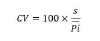
Where:
+ Pi = the arithmetic mean of the monthly rainfall per year 
+ s  = standard deviation of the data set sampled from the population

Subsequently the Precipitation Concentration Index (PCI) is related to the coefficient of variation (CV) using the following equation: 
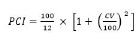

Finally the classification as provided in the table below is applied to characterize the PCI.

PCI Temporal Concentration| PCI Index | code
---:|---:|---:|
Uniform	| < 10 | 1
Moderately concentrated	| 11 - 15 | 2
Concentrated | 16 - 20 | 3
Strongly concentrated | > 20 | 4


Use the precipitation time series,  first calculate the sum and average and then conduct the other required calculations to derive the PCI. Note the combined use of time series data (containing multiple time steps) with a single layer map. 

In [ ]:
pci_Psum = ilwis.do('aggregaterasterstatistics', Pclim, 'sum')

pci_Pmean = ilwis.do('aggregaterasterstatistics', Pclim, 'mean')

pci_s1 = ilwis.do('mapcalc', '@1-@2', Pclim, pci_Pmean)

pci_s2 = ilwis.do('mapcalc','pow(@1,2)', pci_s1) # or sq(@1), see below

pci_avg_s2 = ilwis.do('aggregaterasterstatistics', pci_s2, 'mean')

pci_s = ilwis.do('mapcalc','sqrt(@1)', pci_avg_s2)

pci_cv = ilwis.do('mapcalc','100*(@1/@2)', pci_s, pci_Pmean)

pci = ilwis.do('mapcalc','(100/12)*(1+sq(@1/100))', pci_cv)

In [ ]:
#uncomment line below to store your intermediate result and visualize the output created using ILWIS 386
#pci.store('pci.mpr')

In [ ]:
# create a new NumericItemRange and fill it with required class items
pcirange = ilwis.NumericItemRange()
pcirange.add(('Uniform', 0.0, 10.0, 1.0))
pcirange.add(('Moderately concentrated', 10.0, 15.0, 1.0))
pcirange.add(('Concentrated', 15.0, 20.0, 1.0))
pcirange.add(('Strongly concentrated', 20.0, 500, 1.0))

#assign the range to a new ItemDomain
pci_dom = ilwis.ItemDomain(pcirange)

Conduct the slicing operation and to check the results obtained in ILWIS 386 uncomment the last line in the cell below

In [ ]:
pci_cl = ilwis.do('sliceraster',pci, pci_dom)
#pci_cl.store('pci_cl.mpr')

The same can also be done using the map calculation operator, note the equation provided below and execute the cell

In [ ]:
#apply the Precipitation Concentration Index class intervals using the code column from the PCI table above
PCIcl_mc = ilwis.do('mapcalc','iff((@1>=0)and(@1<10),1,iff((@1>=10)and(@1<15),2,iff((@1>=15)and(@1<20),3,iff(@1>=20,4,?))))', pci)

Visualize your final results obtained

In [ ]:
# create a plot of the numpy array using MatPlotLib - Imshow

dm_indexcl_2np = np.fromiter(iter(dm_indexcl_mc), np.float64, dm_indexcl.size().linearSize()) 
dm_indexcl_2np = dm_indexcl_2np.reshape((dm_index.size().ysize, dm_indexcl.size().xsize))

pci_cl_2np = np.fromiter(iter(PCIcl_mc), np.float64, pci_cl.size().linearSize()) 
pci_cl_2np = pci_cl_2np.reshape((pci_cl.size().ysize, pci_cl.size().xsize))

#plot inline
%matplotlib inline 
fig1 = plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(dm_indexcl_2np, vmin=0, vmax=8, interpolation='none', cmap=ListedColormap(['#FFFFFF',  '#FF0000', '#FF00FF', '#FF8800', '#FFFF00', '#7CFC00', '#00562C', '#4068E1']))
plt.colorbar(fraction=0.025)
plt.title('De Martonne Aridity Index')
plt.subplot(1, 2, 2)
plt.imshow(pci_cl_2np, vmin=0, vmax=5,  interpolation='none', cmap=ListedColormap(['#FFFFFF', '#0000FF', '#1E90FF', '#23B3E9', '#B2D1FF']))
plt.title('Precipitation Concentration Index')
plt.colorbar(fraction=0.025)

In [ ]:
l0 = 50
c0 = 50

l3 = 1000
c3 = 300

PCI_class0 = pci_cl.pix2value(ilwis.Pixel(c0,l0)) # for column,row (x,y) respectively  
PCI_class3 = pci_cl.pix2value(ilwis.Pixel(c3,l3)) # for column,row (x,y) respectively   

PCI_Pclim0 = []
for n in range(0,(Pclim.size().zsize)):
    Pclim_val = (Pclim.pix2value(ilwis.Pixel(c0,l0,n)))
    PCI_Pclim0.append(Pclim_val)
    

PCI_Pclim3 = []
for n in range(0,(Pclim.size().zsize)):
    Pclim_val = (Pclim.pix2value(ilwis.Pixel(c3,l3,n)))
    PCI_Pclim3.append(Pclim_val)

print("PCI class extracted for selected pixel:", PCI_class0)
print("Precipitation values extracted for selected pixel:", PCI_Pclim0)
print()
print("PCI class extracted for selected pixel:", PCI_class3)
print("Precipitation values extracted for selected pixel:", PCI_Pclim3)

In [ ]:
# create a simple plot showing the differences between the classes selected
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(PCI_Pclim0, label='Strongly Concentrated')
plt.plot(PCI_Pclim3, label='Uniform')
plt.ylim([0, 200])
plt.tick_params(labelbottom=False) 
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.title('Precipitation climatology for selected pixels')
plt.legend()

#### Concluding remark:
The combined use of ILWISPy with other Python sitepackages provides a powerfull toolbox to handle and analyse time series data. A number of examples are provided within this notebook. To make the notebook more attractive Matplotlib has been used for visualization of selected graphics and maps. For (time series) visualization it is recommended to use the exisiting (animation) visualization capability as offered by ILWIS 386.